<a href="https://colab.research.google.com/github/YasminaNasser/Stroke-Prediction-Data-Mining/blob/main/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Team Members:**


- Nour Tarek Adel 21p0399
- Farida Waleed Fakhry 21P0167
- Malak Ahmed Yehia 2001350
- Yomna Mohamed Hachem 21P0189
- Yasmina Nasser Hamam 21P0211
- Brwana Ahmed Mourad 20P1346

**GitHub Repo:**

[Stroke-Prediction-Repo](https://colab.research.google.com/github/YasminaNasser/Stroke-Prediction-Data-Mining/blob/google-collab/Stroke_Prediction.ipynb#scrollTo=Jsudh3c5EcU5)



In [59]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1 | Data overview


In [60]:
df=pd.read_csv("/content/healthcare-dataset-stroke-data.csv")
df_cap= df.copy()
df_remove= df.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- id: Identification number of the individual.
- gender: Gender of the individual.
- hypertension: Health related parameter, does person have hypertension.
- heart_disease: Health related parameter, does person have heart disease.
- ever_married: Personal information, is person married on not?
- work_type: Nature of work place.
- Residence_type: Residence type of the individual.
- avg_glucose_level: average glucose level in blood for the individual.
- bmi: body mass index of the individual.
- smoking_status: Habitual information. Current smoking status of individual.
- stroke: Our taget, is person suffered heart attack?

In [61]:
# Display the shape of the DataFrame after removing duplicates
df.shape

(5110, 12)

In [62]:
# Drop column = 'id' , wont needed it in predicting stroke
df.drop('id', axis=1, inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [63]:
print (f' We have {df.shape[0]} instances with the {df.shape[1]-1} features and 1 output variable')

 We have 5110 instances with the 10 features and 1 output variable


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [65]:
def column_info(df):
  cols=[]
  dtypes=[]
  unique_values=[]
  nunique_values=[]

#loop ala kol columns
  for col in df.columns:
    cols.append(col)
    dtypes.append(df[col].dtype)
    unique_values.append(df[col].unique())
    nunique_values.append(df[col].nunique())

#return dataframe fe dictionnaries
  return pd.DataFrame({'column_name':cols,
                        'data_type':dtypes,
                        'unique_values':unique_values,
                        'nunique_values':nunique_values})

column_info(df)

,column_name,data_type,unique_values,nunique_values
0,gender,object,"[Male, Female, Other]",3
1,age,float64,"[67.0, 61.0, 80.0, 49.0, 79.0, 81.0, 74.0, 69....",104
2,hypertension,int64,"[0, 1]",2
3,heart_disease,int64,"[1, 0]",2
4,ever_married,object,"[Yes, No]",2
5,work_type,object,"[Private, Self-employed, Govt_job, children, N...",5
6,Residence_type,object,"[Urban, Rural]",2
7,avg_glucose_level,float64,"[228.69, 202.21, 105.92, 171.23, 174.12, 186.2...",3979
8,bmi,float64,"[36.6, nan, 32.5, 34.4, 24.0, 29.0, 27.4, 22.8...",418
9,smoking_status,object,"[formerly smoked, never smoked, smokes, Unknown]",4


### 1.1 Describe Data

In [66]:
# stats of numerical data
round (df.describe(exclude = 'object'), 2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.0,5110.00,5110.00,4909.00,5110.00
mean,43.23,0.1,0.05,106.15,28.89,0.05
std,22.61,0.3,0.23,45.28,7.85,0.22
min,0.08,0.0,0.00,55.12,10.30,0.00
25%,25.00,0.0,0.00,77.24,23.50,0.00
50%,45.00,0.0,0.00,91.88,28.10,0.00
75%,61.00,0.0,0.00,114.09,33.10,0.00
max,82.00,1.0,1.00,271.74,97.60,1.00


In [67]:
# stats of categorical data
round (df.describe(exclude = ['float', 'int64']),2)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


**Initial Insights:**

Data from bmi feature is missing.

Both Categorical and numerical features are present.

- Categorical Features: gender, ever_married, work_type, Residence_type, smoking_status
- Binary Numerical Features: hypertension,heart_disease, stroke
- Continous Numerical Features: age, avg_glucose_level, bmi

Most of the data is categorical which need a special attention to visualize those.

Feature extraction can be done by binning the continous features ( age, sugar level, and bmi) and let's keep every things as it is.

### 1.2  Categorical Features

In [68]:
# Extract categorical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print("------------------Extracting Categorical Features------------------")
print("Categorical Features:", categorical_features)


------------------Extracting Categorical Features------------------
Categorical Features: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [69]:
# Process each categorical feature
for feature in categorical_features:
    print(f"\nProcessing Feature: {feature}")

    # Get value counts for the feature
    value_counts = df[feature].value_counts(dropna=False)
    print(f"Value Counts:\n{value_counts}")



Processing Feature: gender
Value Counts:
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

Processing Feature: ever_married
Value Counts:
ever_married
Yes    3353
No     1757
Name: count, dtype: int64

Processing Feature: work_type
Value Counts:
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

Processing Feature: Residence_type
Value Counts:
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64

Processing Feature: smoking_status
Value Counts:
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64


# Step 2 | Preprocessing Techniques


## 2.1 Check Nulls

In [70]:
# check null
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201
smoking_status,0


the missing values of bmi are nulls.

In [71]:
print((df.isna().sum()/len(df))*100)

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64


There is 201 samples with no values in bmi column , its about 4% of data.

## 2.2 Check Duplicates

In [72]:
# Find duplicate rows
duplicate_rows = df[df.duplicated()]

print("\n------------------Checking for Duplicate Rows------------------")
if not duplicate_rows.empty:
    print(f"Number of duplicate rows: {len(duplicate_rows)}")
    print("Duplicate Rows:\n", duplicate_rows)
else:
    print("No exact duplicate rows found.")



------------------Checking for Duplicate Rows------------------
No exact duplicate rows found.


## 2.3 Check Coorelation between features

In [73]:
# Create a copy of the DataFrame to work with numeric data
df_numeric = df.copy()

# Encode categorical variables
for col in df_numeric.select_dtypes(include=['object', 'category']).columns:
    print(f"Encoding categorical column: {col}")
    df_numeric[col] = LabelEncoder().fit_transform(df_numeric[col])

# Display the first few rows of the numeric DataFrame
df_numeric.head()

Encoding categorical column: gender
Encoding categorical column: ever_married
Encoding categorical column: work_type
Encoding categorical column: Residence_type
Encoding categorical column: smoking_status


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,0,61.0,0,0,1,3,0,202.21,NaN,2,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,0,79.0,1,0,1,3,0,174.12,24.0,2,1


In [74]:
# Calculate the correlation matrix
corr_matrix = df_numeric.corr()

# Print all the features in the correlation matrix
print("\nFeatures in the Correlation Matrix:")
print(corr_matrix.columns.tolist())


Features in the Correlation Matrix:
['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


In [75]:
# Display the correlation matrix as a DataFrame
corr_matrix

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,1.000000,-0.028202,0.020994,0.085447,-0.031005,0.056422,-0.006738,0.055180,-0.026678,-0.062581,0.008929
age,-0.028202,1.000000,0.276398,0.263796,0.679125,-0.361642,0.014180,0.238171,0.333398,0.265199,0.245257
hypertension,0.020994,0.276398,1.000000,0.108306,0.164243,-0.051761,-0.007913,0.174474,0.167811,0.111038,0.127904
heart_disease,0.085447,0.263796,0.108306,1.000000,0.114644,-0.028023,0.003092,0.161857,0.041357,0.048460,0.134914
ever_married,-0.031005,0.679125,0.164243,0.114644,1.000000,-0.352722,0.006261,0.155068,0.341695,0.259647,0.108340
work_type,0.056422,-0.361642,-0.051761,-0.028023,-0.352722,1.000000,-0.007316,-0.050513,-0.304876,-0.305927,-0.032316
Residence_type,-0.006738,0.014180,-0.007913,0.003092,0.006261,-0.007316,1.000000,-0.004946,-0.000122,0.008237,0.015458
avg_glucose_level,0.055180,0.238171,0.174474,0.161857,0.155068,-0.050513,-0.004946,1.000000,0.175502,0.063437,0.131945
bmi,-0.026678,0.333398,0.167811,0.041357,0.341695,-0.304876,-0.000122,0.175502,1.000000,0.224473,0.042374
smoking_status,-0.062581,0.265199,0.111038,0.048460,0.259647,-0.305927,0.008237,0.063437,0.224473,1.000000,0.028123


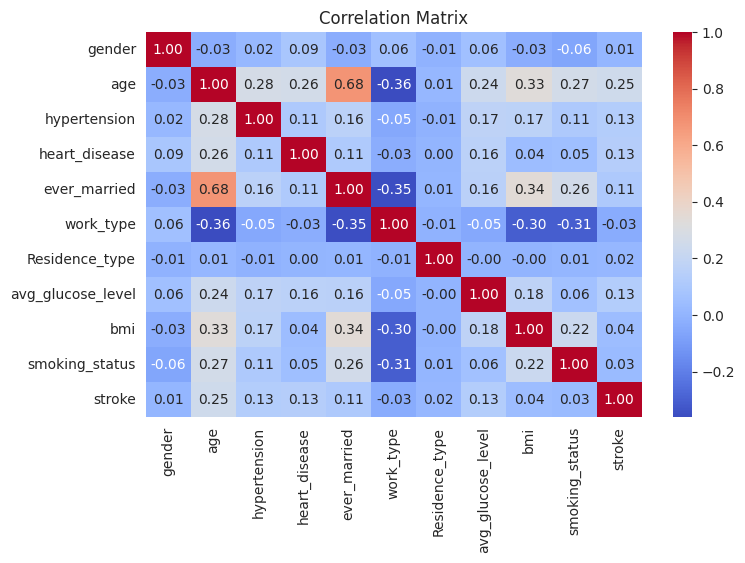

In [76]:
# Visualize the correlation matrix
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

ever_married and age have strong relation.



In [77]:
# Initialize parameters
threshold = 0.003550
reason = "The column is detected as not contributing significantly to other features."
columns_to_drop = []

# Iterate over each column to check its correlation with others
for column in corr_matrix.columns:
    # Get correlations of the current column with all others (excluding itself)
    column_correlation = corr_matrix[column].drop(column)

    # Check if all correlations are below the threshold
    if all(abs(column_correlation) < threshold) and column not in columns_to_drop:
        columns_to_drop.append(column)
        print(f"Detected '{column}' column as not contributing significantly to other columns, removing it.")
        print(f"Reason: {reason}")

# Display the list of columns to drop
print(f"Columns to drop: {columns_to_drop}")


Columns to drop: []


## 2.4 Imputations of nulls

In [78]:
# Identify numerical features (excluding the last column)
numerical_features = df.iloc[:, :-1].select_dtypes(include=[np.number]).columns.tolist()

print("------------------ Extracting Numerical Features ------------------")
print(numerical_features)

# Create a DataFrame with only numerical features (excluding the target column)
dataframe_N = df[numerical_features]

print("------------------ Numerical DataFrame ------------------------")
dataframe_N.head()

------------------ Extracting Numerical Features ------------------
['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
------------------ Numerical DataFrame ------------------------


,age,hypertension,heart_disease,avg_glucose_level,bmi
0,67.0,0,1,228.69,36.6
1,61.0,0,0,202.21,NaN
2,80.0,0,1,105.92,32.5
3,49.0,0,0,171.23,34.4
4,79.0,1,0,174.12,24.0


### 2.4.1 BMI Nulls heatmap

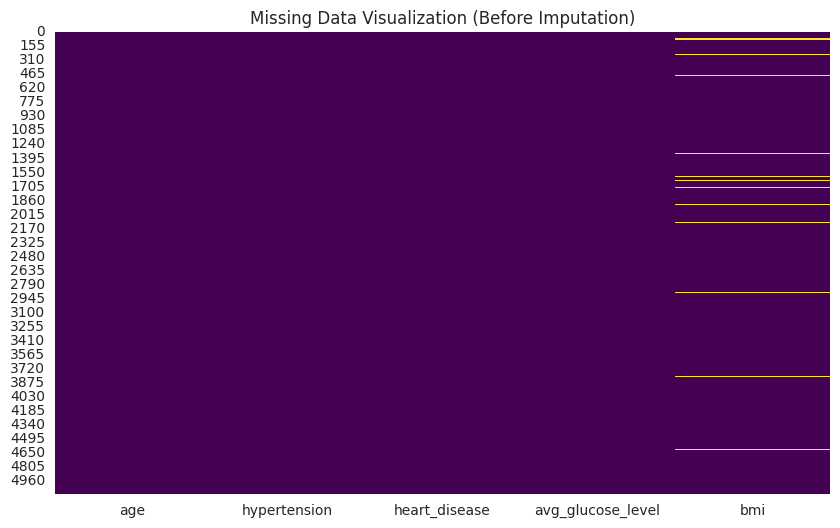

In [79]:
# Visualization of missing data before imputation
plt.figure(figsize=(10, 6))
sns.heatmap(dataframe_N.isnull(), cbar=False, cmap='viridis', cbar_kws={'label': 'Missing Data'})
plt.title('Missing Data Visualization (Before Imputation)')
plt.show()

### 2.4.2 Impute with mean

In [80]:
# Replace NaN values with the mean of each column
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
dataframe_N_imputed = imp_mean.fit_transform(dataframe_N)

# Convert the NumPy array back to a DataFrame with the original column names
dataframe_N_imputed = pd.DataFrame(dataframe_N_imputed, columns=numerical_features)

print("------------------ Data After Imputation ------------------------")
dataframe_N_imputed.head()


------------------ Data After Imputation ------------------------


,age,hypertension,heart_disease,avg_glucose_level,bmi
0,67.0,0.0,1.0,228.69,36.600000
1,61.0,0.0,0.0,202.21,28.893237
2,80.0,0.0,1.0,105.92,32.500000
3,49.0,0.0,0.0,171.23,34.400000
4,79.0,1.0,0.0,174.12,24.000000


### 2.4.3 Normalize after imputation

In [81]:
# Normalize the data to a range of [0, 1]
normalizer = MinMaxScaler(feature_range=(0, 1))
dataframe_N_normalized = normalizer.fit_transform(dataframe_N_imputed)

# Convert the normalized array back to a DataFrame with the original column names
dataframe_N_normalized = pd.DataFrame(dataframe_N_normalized, columns=numerical_features)

print("------------------ Data After Normalization ------------------------")
dataframe_N_normalized.head()

------------------ Data After Normalization ------------------------


,age,hypertension,heart_disease,avg_glucose_level,bmi
0,0.816895,0.0,1.0,0.801265,0.301260
1,0.743652,0.0,0.0,0.679023,0.212981
2,0.975586,0.0,1.0,0.234512,0.254296
3,0.597168,0.0,0.0,0.536008,0.276060
4,0.963379,1.0,0.0,0.549349,0.156930


In [82]:
# Update the original dataset with the normalized numerical features
df[numerical_features] = dataframe_N_normalized

print("------------------- Data After Handling Missing Values and Normalization ---------------")
df.head()

------------------- Data After Handling Missing Values and Normalization ---------------


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,0.816895,0.0,1.0,Yes,Private,Urban,0.801265,0.301260,formerly smoked,1
1,Female,0.743652,0.0,0.0,Yes,Self-employed,Rural,0.679023,0.212981,never smoked,1
2,Male,0.975586,0.0,1.0,Yes,Private,Rural,0.234512,0.254296,never smoked,1
3,Female,0.597168,0.0,0.0,Yes,Private,Urban,0.536008,0.276060,smokes,1
4,Female,0.963379,1.0,0.0,Yes,Self-employed,Rural,0.549349,0.156930,never smoked,1


# Step 3 | Outliers Detection

In this analysis, both **capping** and **removing** outliers will be implemented to address extreme values in the dataset.

The goal is to evaluate and compare the impact of these two methods on the data distribution and overall trends.

By *capping outliers*, extreme values are adjusted to *lie within statistically acceptable bounds*, preserving all data points while mitigating their influence on analysis.

Conversely, *removing outlier*s entirely excludes rows with extreme values, simplifying the dataset but *potentially discarding valuable information*.

 By applying both techniques to the same dataset and visualizing the results, we can better understand their respective **advantages**, **limitations**, and the contexts in which each method is more appropriate.

In [83]:
# Skip outlier detection if the column has only 2 unique values
numerical_features = ['age', 'avg_glucose_level', 'bmi']

# Display the initial data
df_cap.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### 3.1 Distribution Before Handling Outliers


<ipython-input-84-f9200df40ef5>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True)


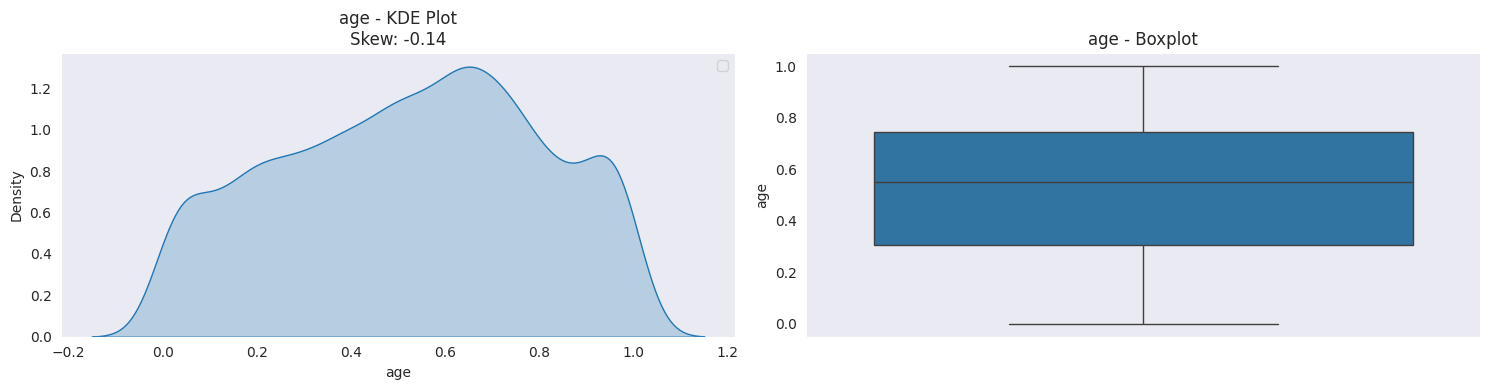

<ipython-input-84-f9200df40ef5>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True)


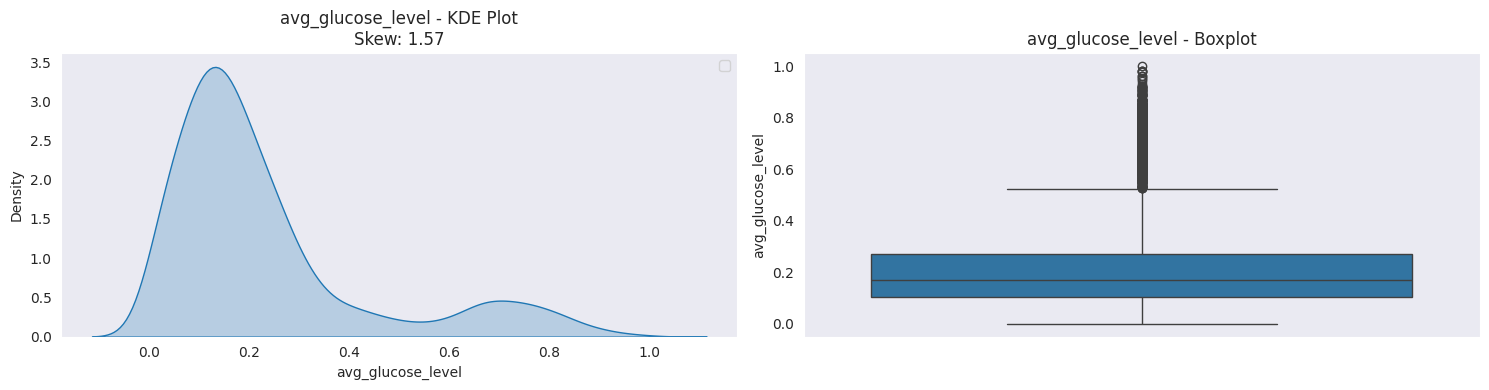

<ipython-input-84-f9200df40ef5>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True)


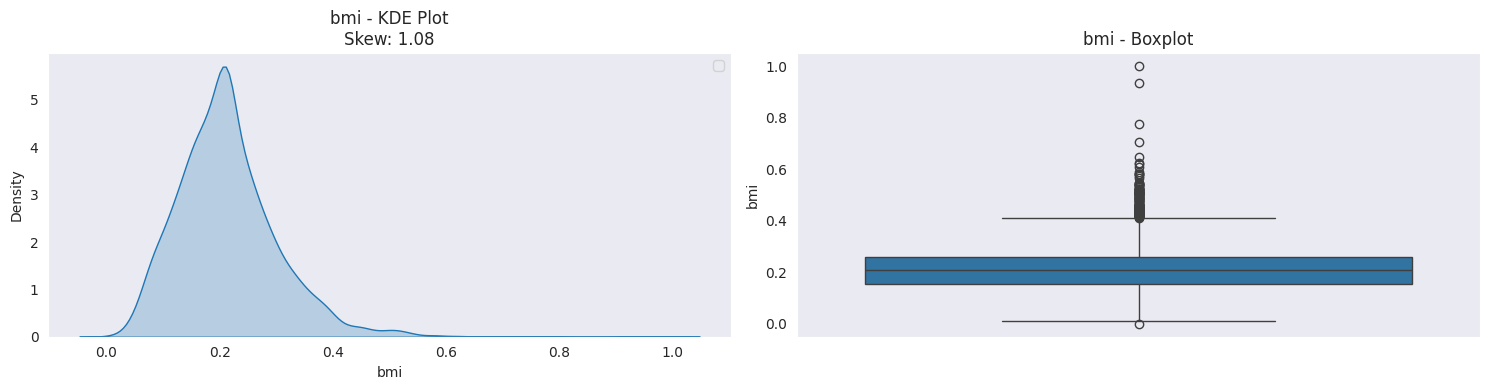

In [84]:
sns.set_style('dark')
for col in numerical_features:
    plt.figure(figsize=(15,4))

    # KDE plot
    plt.subplot(1, 2, 1)
    sns.kdeplot(df[col], shade=True)
    plt.title(f"{col} - KDE Plot\nSkew: {np.round(df[col].skew(), 2)}")
    plt.legend()

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(df[col])
    plt.title(f"{col} - Boxplot")

    plt.tight_layout()
    plt.show()

## 3.2 Detecting The Outliers

### 3.2.1 Detect Using IQR

In [85]:
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((column < lower_bound) | (column > upper_bound))
    return outliers

In [86]:
# calculating the percentage of outliers in each numerical column
iqr_flages = pd.DataFrame()

for column in numerical_features:
    outliers = detect_outliers_iqr(df[column])
    iqr_flages[column] = outliers
    percentage = len(outliers[outliers == True]) / len(df[column]) * 100
    print(f"{column}: {percentage:.2f}% outliers")

iqr_out_indx_DF = iqr_flages.any(axis=1)
percentage = len(iqr_out_indx_DF[iqr_out_indx_DF == True]) / len(df[column]) * 100
print(f"Total: {percentage:.2f}% outliers")

age: 0.00% outliers
avg_glucose_level: 12.27% outliers
bmi: 2.47% outliers
Total: 14.07% outliers


In [87]:
iqr_flages.head()

,age,avg_glucose_level,bmi
0,False,True,False
1,False,True,False
2,False,False,False
3,False,True,False
4,False,True,False


### 3.2.2 Detect Using Z-score

In [88]:
def detect_outliers_zscore(column):
    colmean =  column.mean()
    colstd = column.std(ddof=0)
    DFZ = ((column - colmean)/colstd).copy()
    outliers = ((DFZ < -3) | (DFZ > 3))
    return outliers

In [89]:
zscore_flags = pd.DataFrame()

for column in numerical_features:
    outliers = detect_outliers_zscore(df[column])
    zscore_flags[column] = outliers
    percentage = len(outliers[outliers == True]) / len(df[column]) * 100
    print(f"{column}: {percentage:.2f}% outliers")

zscore_flags = zscore_flags.any(axis=1)
percentage = len(zscore_flags[zscore_flags == True]) / len(df[column]) * 100
print(f"Total: {percentage:.2f}% outliers")

age: 0.00% outliers
avg_glucose_level: 0.96% outliers
bmi: 1.15% outliers
Total: 2.11% outliers


In [90]:
zscore_flags.head()

,0
0,False
1,False
2,False
3,False
4,False


Regarding the avg_glucose_level , we used 2 measures of outlier detection since deleting 14% of our total dataset seemed too much and unreasonable, so removing outliers in this case would lead in loss of important information.

That's why we will focus more on the Z-Score outlier detection cleaned dataset moving forward

## 3.3 Handling The Outliers

### 3.3.1 Removing The Outliers

The removal of outliers involves excluding data points that fall outside a defined range, typically based on statistical measures like the Z-score.

By removing outliers, the dataset becomes more homogeneous, reducing the potential for extreme values to distort statistical analyses, such as mean, variance, or regression models.

This method can be particularly effective when outliers are due to data entry errors, measurement inaccuracies, or conditions that are not relevant to the analysis.

 However, while removing outliers can improve model accuracy and reduce noise, it may also lead to a loss of valuable information, especially if the outliers represent natural variations or rare but significant observations.

 Moreover, the reduction in sample size may weaken the robustness of the analysis and affect the generalizability of the results.

In [91]:
# Remove outliers from numerical features
# Detect and remove outliers from numerical features using Z-score
for column in numerical_features:
    # Detect outliers using the Z-score method
    outliers = detect_outliers_zscore(df_remove[column])

    # Filter out rows that are outliers for the current column
    df_remove = df_remove[~outliers]

# Reset the index of the cleaned DataFrame
df_remove.reset_index(drop=True, inplace=True)

# Display the cleaned data
print(f"Data after removing outliers:")
df_remove.head()

Data after removing outliers:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### Distribution Before and After Removal Of Outliers

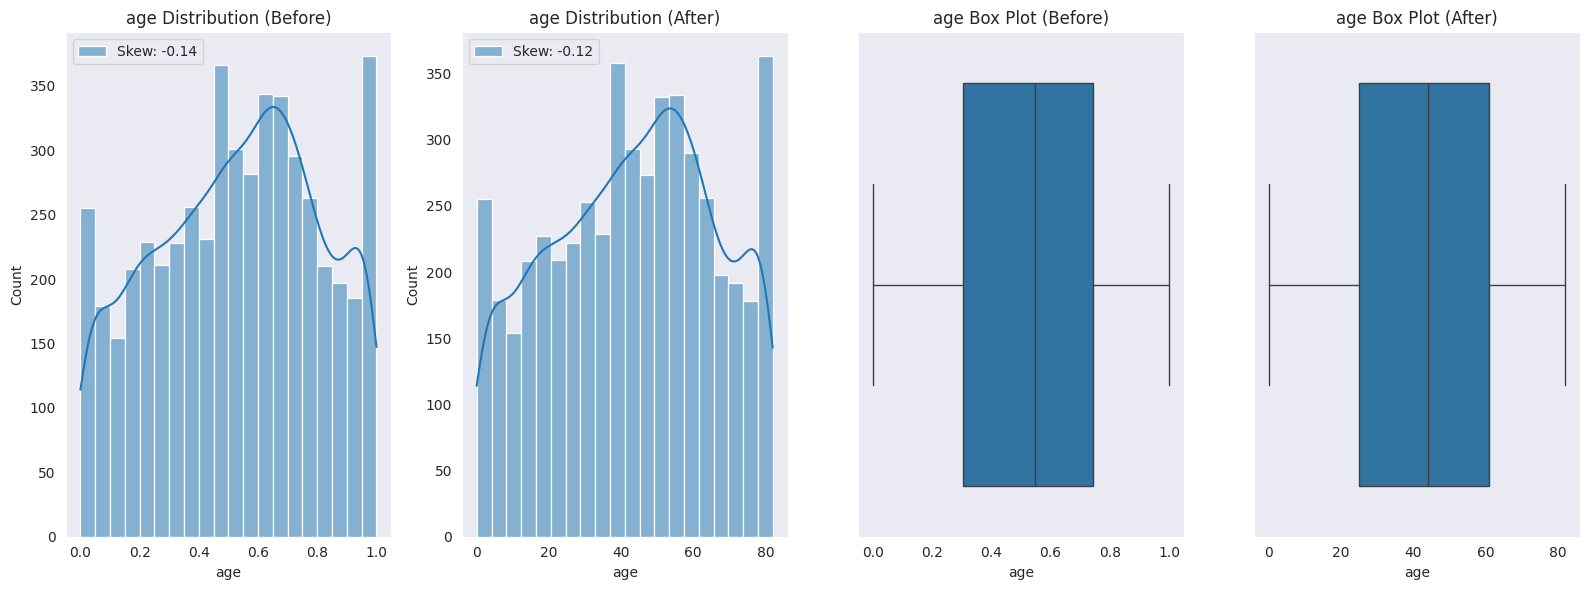

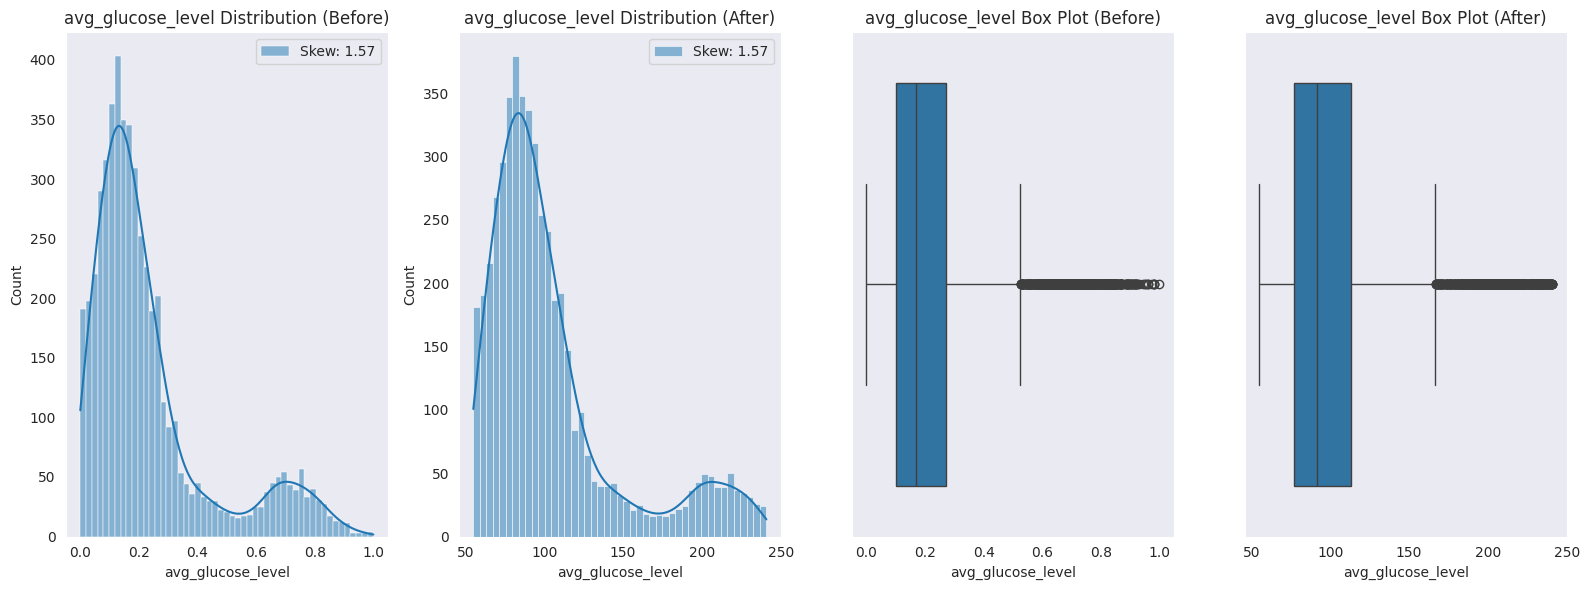

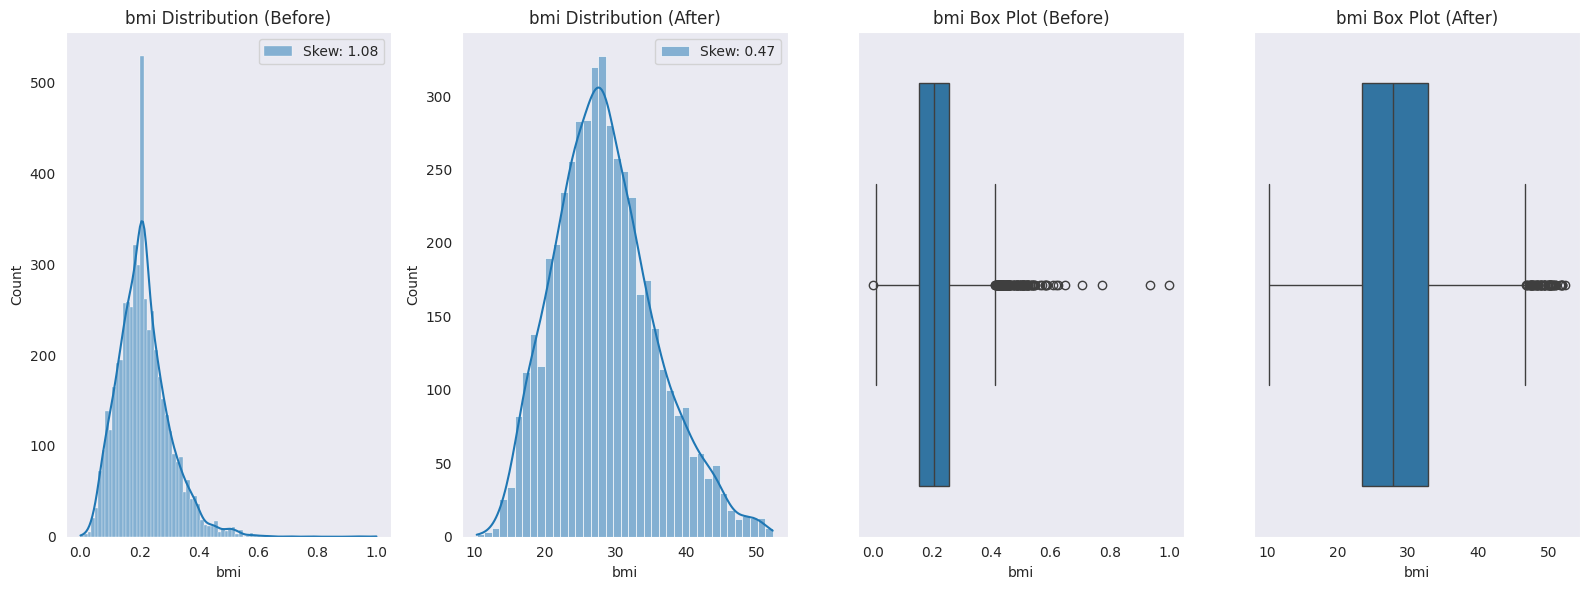

In [92]:
# Plot distributions and box plots for each numerical feature
for col in numerical_features:
    plt.figure(figsize=(16, 6))

    # Distribution plot before outlier removal
    plt.subplot(141)
    sns.histplot(df[col], kde=True, label="Skew: " + str(np.round(df[col].skew(), 2)))
    plt.title(f'{col} Distribution (Before)')
    plt.legend()

    # Distribution plot after outlier removal
    plt.subplot(142)
    sns.histplot(df_remove[col], kde=True, label="Skew: " + str(np.round(df_remove[col].skew(), 2)))
    plt.title(f'{col} Distribution (After)')
    plt.legend()

    # Box plot before outlier removal
    plt.subplot(143)
    sns.boxplot(x=df[col])
    plt.title(f'{col} Box Plot (Before)')

    # Box plot after outlier removal
    plt.subplot(144)
    sns.boxplot(x=df_remove[col])
    plt.title(f'{col} Box Plot (After)')

    plt.tight_layout()
    plt.show()

###3.3.2 Capping The Outliers

Capping outliers involves adjusting extreme values to fall within a specified range, rather than removing them from the dataset.

This method helps reduce the impact of outliers without losing any data points.

 By setting a cap, values that are too high or too low are replaced with the maximum or minimum acceptable value, based on statistical measures like zscore.

 Capping helps make the dataset more balanced and prevents outliers from distorting statistical results, such as averages or correlations.

 While it preserves all data, it can introduce some bias if the capped values no longer reflect the true extremes of the data.

 Overall, capping is useful when you want to maintain the dataset size but still minimize the influence of extreme values

In [93]:
# Loop through numerical features and cap outliers using Z-score
for col in numerical_features:
    # Detect outliers using Z-score
    outliers = detect_outliers_zscore(df[col])

    # Calculate the mean ± 3 standard deviations for capping
    lower_bound = df[col].mean() - 3 * df[col].std(ddof=0)
    upper_bound = df[col].mean() + 3 * df[col].std(ddof=0)

    # Cap the outliers
    df_cap[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df_cap[col] = np.where(df_cap[col] > upper_bound, upper_bound, df_cap[col])

# Display the capped data
print(f"Data after capping outliers:")
df_cap.head()

Data after capping outliers:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,0.816895,0,1,Yes,Private,Urban,0.801265,0.301260,formerly smoked,1
1,51676,Female,0.743652,0,0,Yes,Self-employed,Rural,0.679023,0.212981,never smoked,1
2,31112,Male,0.975586,0,1,Yes,Private,Rural,0.234512,0.254296,never smoked,1
3,60182,Female,0.597168,0,0,Yes,Private,Urban,0.536008,0.276060,smokes,1
4,1665,Female,0.963379,1,0,Yes,Self-employed,Rural,0.549349,0.156930,never smoked,1


#### Distribution Before and After Capping Of Outliers

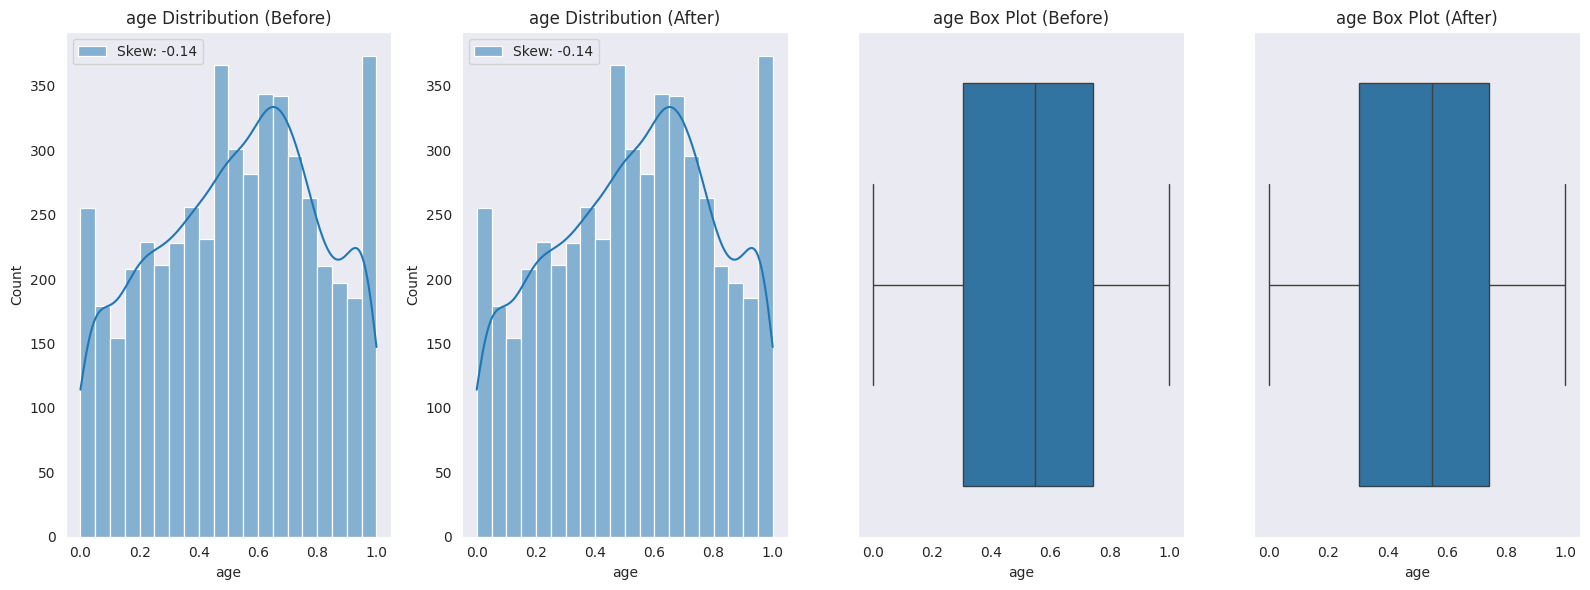

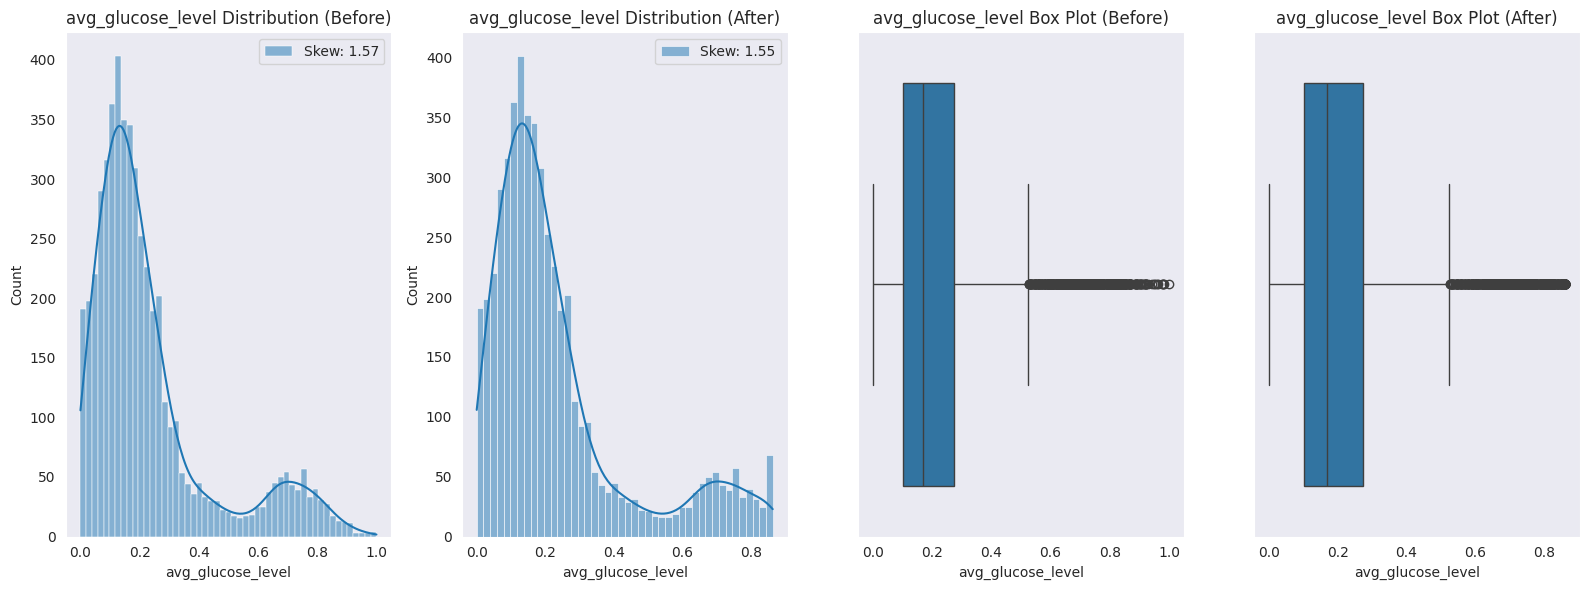

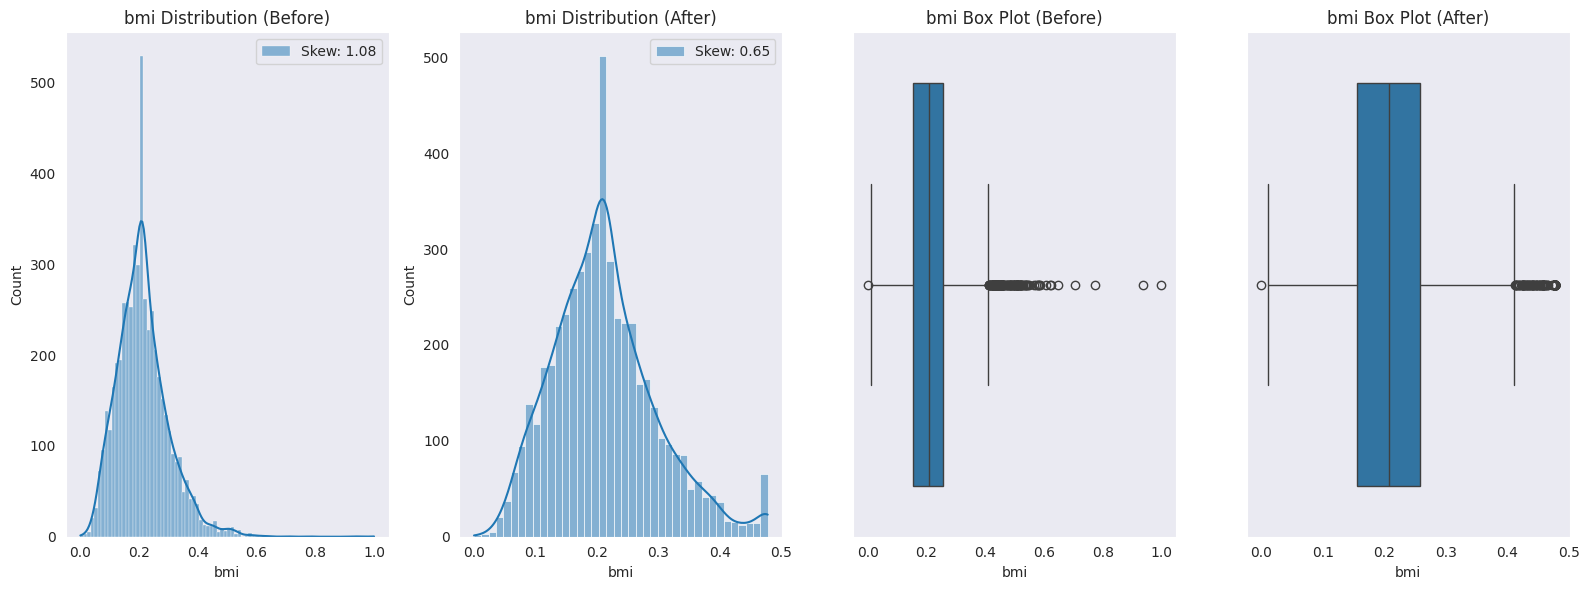

In [94]:
for col in numerical_features:
    plt.figure(figsize=(16, 6))

    # Distribution plot before capping
    plt.subplot(141)
    sns.histplot(df[col], kde=True, label="Skew: " + str(np.round(df[col].skew(), 2)))
    plt.title(f'{col} Distribution (Before)')
    plt.legend()

    # Distribution plot after capping
    plt.subplot(142)
    sns.histplot(df_cap[col], kde=True, label="Skew: " + str(np.round(df_cap[col].skew(), 2)))
    plt.title(f'{col} Distribution (After)')
    plt.legend()

    # Box plot before capping
    plt.subplot(143)
    sns.boxplot(x=df[col])
    plt.title(f'{col} Box Plot (Before)')

    # Box plot after capping
    plt.subplot(144)
    sns.boxplot(x=df_cap[col])
    plt.title(f'{col} Box Plot (After)')

    plt.tight_layout()
    plt.show()

# Step 4 | Unbalance

In [95]:
y = df['stroke']
print(f'Percentage of patient had a stroke: % {round(y.value_counts(normalize=True)[1]*100,2)} --> ({y.value_counts()[1]} patient)\nPercentage of patient did not have a stroke: % {round(y.value_counts(normalize=True)[0]*100,2)} --> ({y.value_counts()[0]} patient)')

Percentage of patient had a stroke: % 4.87 --> (249 patient)
Percentage of patient did not have a stroke: % 95.13 --> (4861 patient)


# Step 5 | Data Analysis


In [96]:
# Define the plot_hist function
def plot_hist(col, bins=30, title="", xlabel="", ax=None):
    sns.histplot(col, bins=bins, ax=ax, kde=False)  # sns.distplot is deprecated, replaced with sns.histplot
    ax.set_title(f'Histogram of {title}', fontsize=20)
    ax.set_xlabel(xlabel)

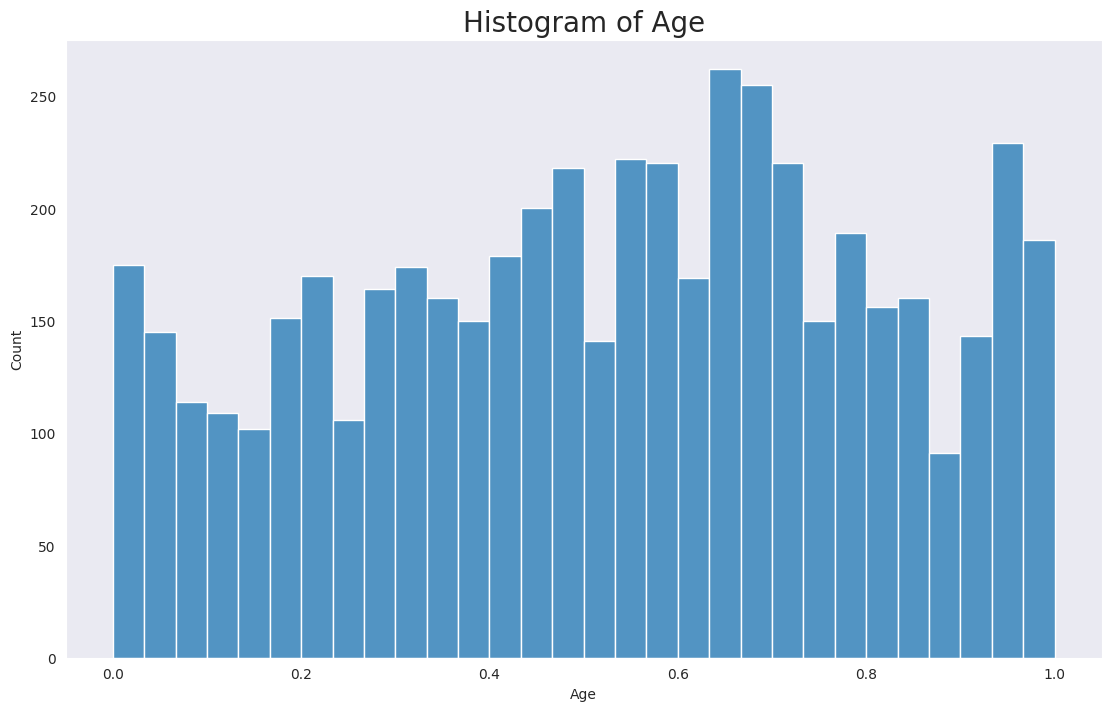

In [97]:
# Create the figure and axes
fig, ax = plt.subplots(1, 1, figsize=(11, 7), constrained_layout=True)

# Call the function with a single axis
plot_hist(df_cap["age"], bins=30, title='Age', xlabel='Age', ax=ax)
plt.show()

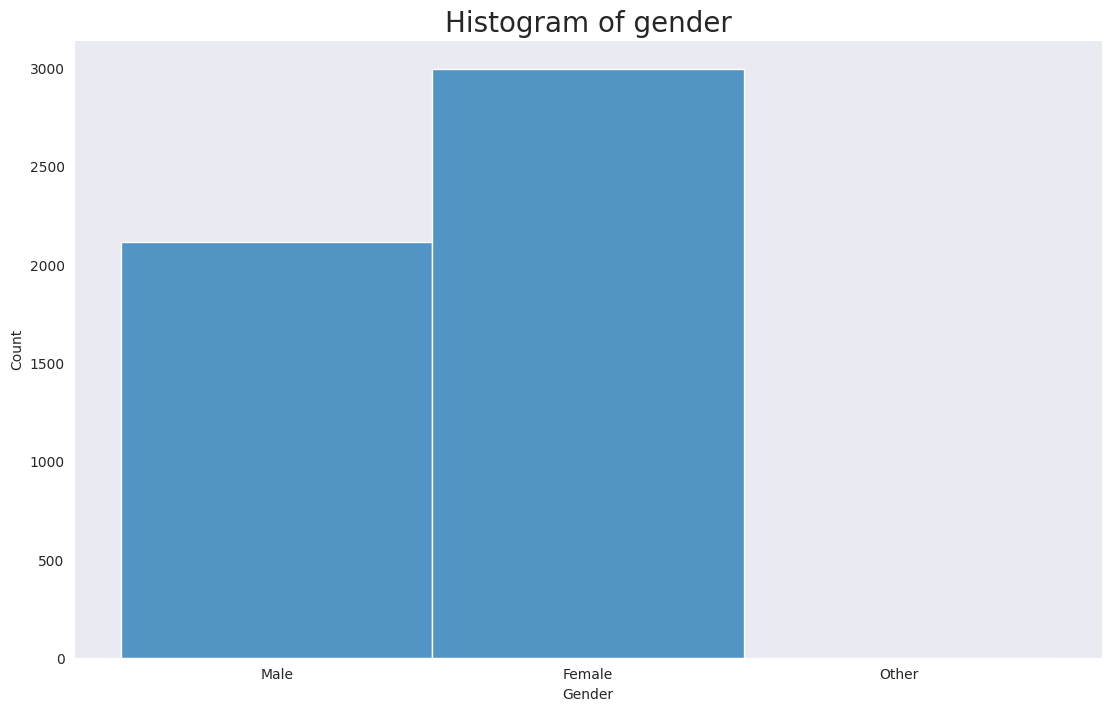

In [98]:
# Create the figure and axes
fig, ax = plt.subplots(1, 1, figsize=(11, 7), constrained_layout=True)

plot_hist(df_cap["gender"],
          bins=2,
          title='gender',
          xlabel='Gender',
          ax=ax)

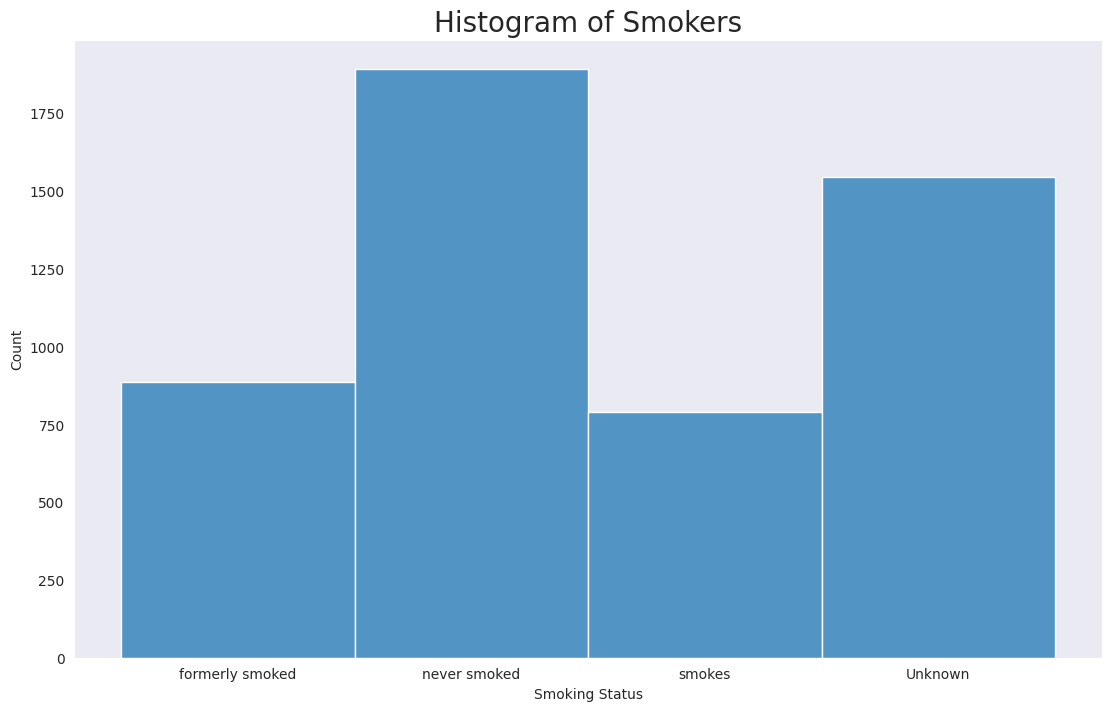

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7), constrained_layout=True)
plot_hist(df_cap["smoking_status"],
          bins=4,
          title='Smokers',
          xlabel='Smoking Status',
          ax=ax)

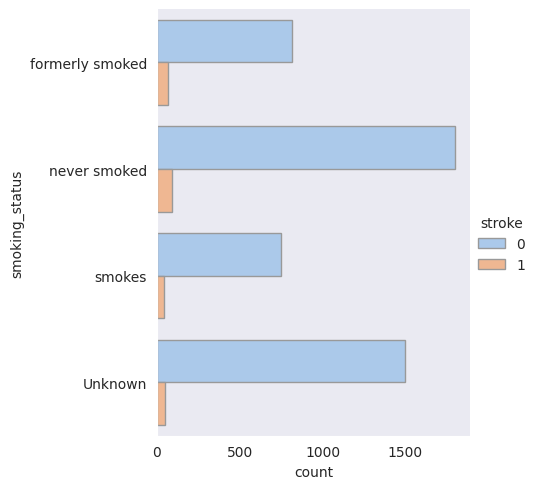

In [100]:
sns.catplot(y="smoking_status", hue="stroke", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_cap)

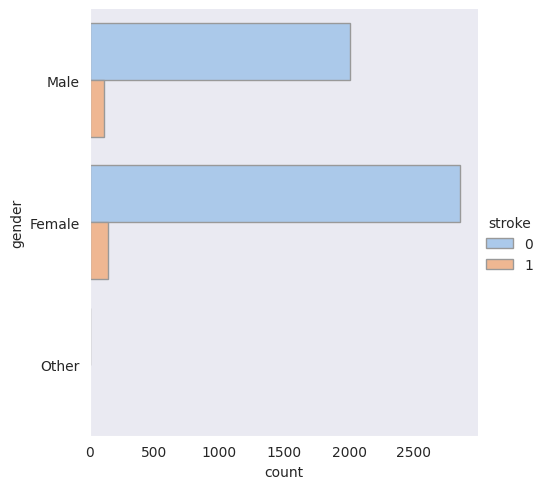

In [101]:
sns.catplot(y="gender", hue="stroke", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_cap)

<ipython-input-102-afefdaa4465d>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Correlation coefficient", y="Features",


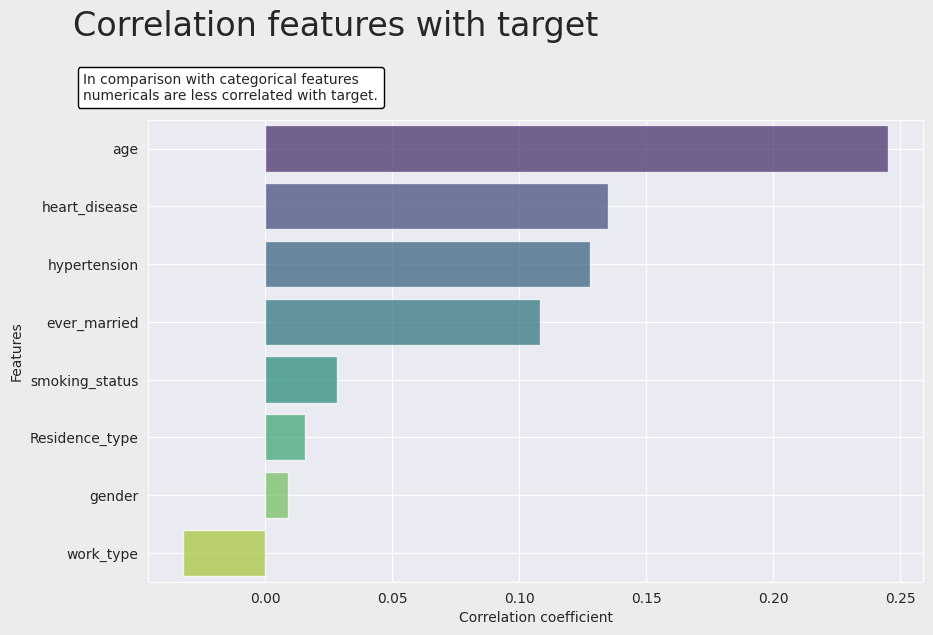

In [102]:
features=['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type',
       'smoking_status']
from matplotlib.offsetbox import AnchoredText
df_numeric = df.copy()
for col in df_numeric.select_dtypes(include=['object', 'category']).columns:
    df_numeric[col] = LabelEncoder().fit_transform(df_numeric[col])

correlation_table = []
for cols in features:
    y = df_numeric["stroke"]
    x = df_numeric[cols]
    corr = np.corrcoef(x, y)[1][0]
    dict ={
        'Features': cols,
        'Correlation coefficient' : corr,
        'Feat_type': 'numerical'
    }
    correlation_table.append(dict)
dF1 = pd.DataFrame(correlation_table)
fig = plt.figure(figsize=(10,6), facecolor='#EAECEE')
ax = sns.barplot(x="Correlation coefficient", y="Features",
                     data=dF1.sort_values("Correlation coefficient", ascending=False),
                     palette='viridis', alpha=0.75)
ax.grid()
#ax.set_title("Correlation of numerical features with Target", fontsize=20, y=1.05)

title =  'Correlation features with target'
sub_title = 'In comparison with categorical features \
\nnumericals are less correlated with target.'

plt.gcf().text(0.05, 1.02, title, fontsize=24)
#plt.gcf().text(0.05, 0.9, sub_title, fontsize=14)

at1 = AnchoredText(sub_title,
                   loc='lower left', frameon=True,
                   bbox_to_anchor=(-0.1, 1.01),
                   bbox_transform=ax.transAxes,
                   #prop=dict(size=8),
                   )
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at1)

<h1> Decision Tree Classifier</h1>

In [103]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix


X = df_numeric.drop(columns=['stroke'])  # Features
y = df_numeric['stroke']  # Target column

# Split dataset into training and testing sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create Decision Tree Classifier object
clf = DecisionTreeClassifier()

# Train the classifier
clf = clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Classification report
class_report = classification_report(y_test, y_pred, target_names=['No Stroke', 'Stroke'], output_dict=True)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display results
print("=" * 50)
print("Model Evaluation Results")
print("=" * 50)
print(f"Accuracy: {accuracy * 100:.2f}%\n")

# Print classification report as a table
print("Classification Report:")
class_report_df = pd.DataFrame(class_report).transpose()
print(class_report_df.round(2), "\n")

# Display confusion matrix as a table
cm_df = pd.DataFrame(cm,
                     index=['Actual: No Stroke', 'Actual: Stroke'],
                     columns=['Predicted: No Stroke', 'Predicted: Stroke'])
print("Confusion Matrix:")
print(cm_df)
TN, FP, FN, TP = cm.ravel()
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print("=" * 50)





Model Evaluation Results
Accuracy: 91.39%

Classification Report:
              precision  recall  f1-score  support
No Stroke          0.95    0.96      0.95   962.00
Stroke             0.23    0.20      0.21    60.00
accuracy           0.91    0.91      0.91     0.91
macro avg          0.59    0.58      0.58  1022.00
weighted avg       0.91    0.91      0.91  1022.00 

Confusion Matrix:
                   Predicted: No Stroke  Predicted: Stroke
Actual: No Stroke                   922                 40
Actual: Stroke                       48                 12
False Positives (FP): 40
False Negatives (FN): 48


# <h2>Visualizing</h2>

**Visualizing Decision Tree **

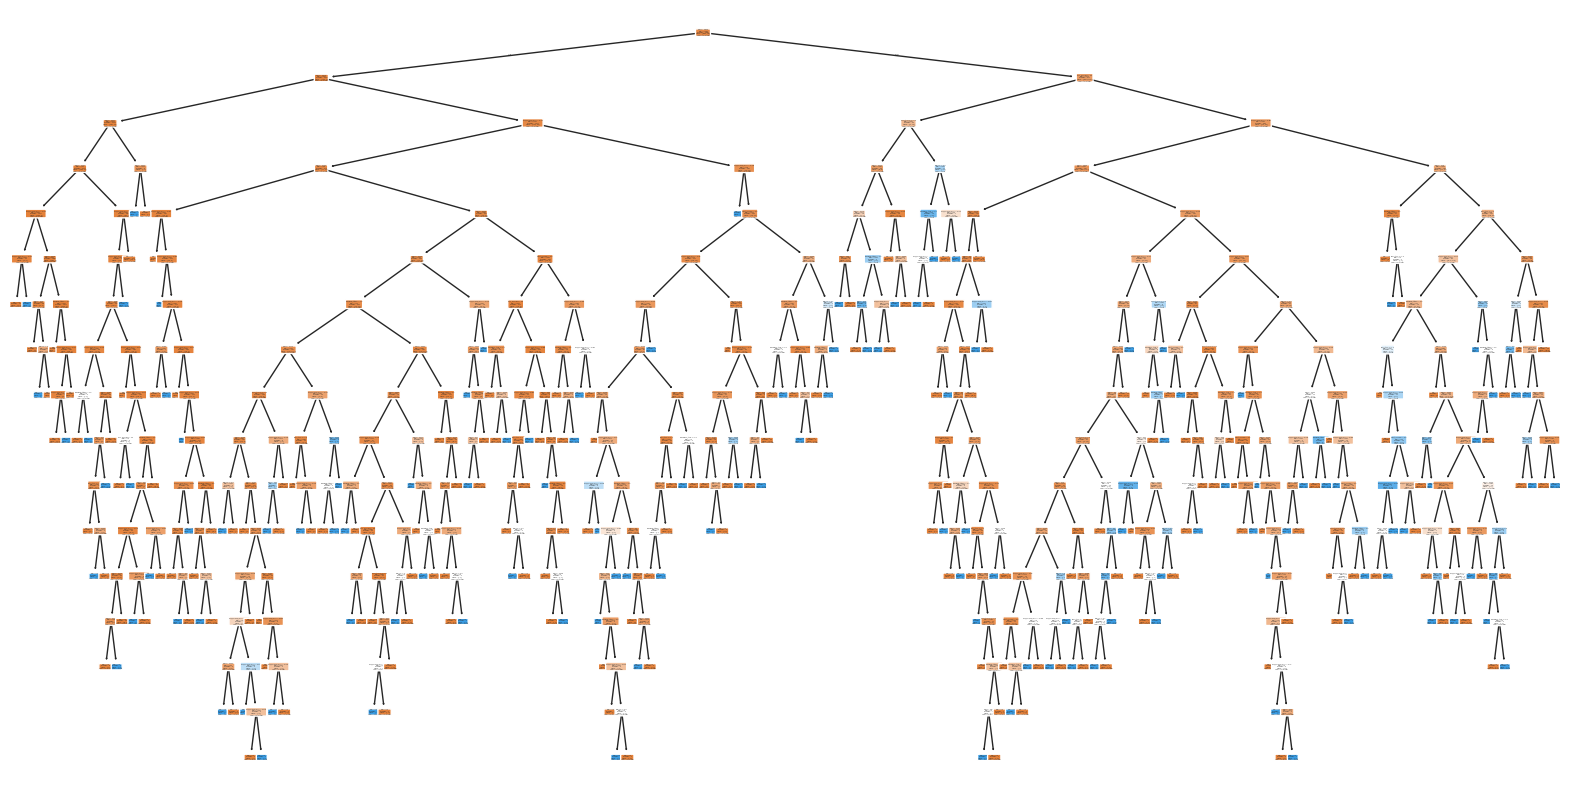

In [104]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plot the Decision Tree
plt.figure(figsize=(20, 10))  # Adjust figure size as needed
plot_tree(clf,
          feature_names=X.columns,  # Feature names from your dataset
          class_names=['No Stroke', 'Stroke'],  # Class names
          filled=True,  # Fill nodes with colors
          rounded=True)  # Rounded edges for better visualization
plt.show()


**visualizing second** **approach** **Saving as pdf**

In [105]:
# !apt-get install -y graphviz
# !pip install graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [106]:
from sklearn.tree import export_graphviz
import graphviz

# Export the Decision Tree to a DOT format
dot_data = export_graphviz(clf,
                           out_file=None,
                           feature_names=X.columns,
                           class_names=['No Stroke', 'Stroke'],
                           filled=True,
                           rounded=True)

# Render the DOT file as an image
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Saves as 'decision_tree.pdf'

# Display the tree directly in Colab
graph.view()




'decision_tree.pdf'

# **save the model**

In [107]:
import joblib

# Save the model to a file
joblib.dump(clf, 'decision_tree_model.pkl')

print("Model saved as 'decision_tree_model.pkl'")


Model saved as 'decision_tree_model.pkl'
